# Ejercicio 1 - Análisis descriptivo

Responder a la pregunta: **¿Cuáles son los lenguajes de programación asociados a los mejores salarios?**

Para ello:
1. Seleccionar las columnas relevantes para analizar.
2. Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en una sub-población. Por ejemplo, se pueden limitar a personas con un salario mayor que 10000 pesos, o a las personas que trabajan sólo en "Data Science", pero deben justificar su elección y reformular la pregunta inicial de ser necesario.
  * Obtener una lista de los lenguajes de programación más populares. Decidir cuántos y cuáles seleccionan para incluir en el análisis.
  * Para cada una de las otras columnas del punto anterior, elegir los rangos o valores seleccionan para incluir en el análisis.
3. Seleccionar métricas que ayuden a responder la pregunta, y los métodos para analizarlas. Elegir UNA de las siguientes opciones:
  * Comparar las distribuciones de salario para cada lenguaje utilizando visualizaciones. Como la visualización es el producto final, debe ser clara y mostrar información relevante.
  * Comparar medidas de estadística descriptiva sobre la distribución de salario para cada lenguaje. Sean creativos, la estadística descriptiva nos permite decir cosas como: "el 10% de los mejores sueldos los ganan, en su mayoría, programadores que saben kotlin!" (donde *mayoría* es un término medio engañoso que sólo significa más del 50%). Para comparar múltiples lenguajes, les recomendamos usar también visualizaciones.
  * Comparar probabilidades. Por ejemplo: "Si sabés Python o Java, tenés un 30% más de chances de ganar arriba de 100K".

Si lo consideran necesario, realicen varias iteraciones. Es decir, si encuentran que las distribuciones de los lenguajes de programación que seleccionaron inicialmente no son muy diferentes, pueden re-hacer el análisis usando sólo los lenguajes de programación que son diferentes.

# Imports

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [10, 5]
import numpy as np
import warnings
import scipy
from scipy import stats
warnings.simplefilter("ignore")

pd.set_option('display.max_rows', 500)


# Lectura del archivo CSV

In [4]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

# Preprocessing

Se aplica la función "split_languages" para expandir al rows cada lenguaje de programación. Se considera a cada lenguaje de programación que sabe el encuestado como un dato  particular. Terminamos con **df_lang** como dataframe final para empezar los análisis de estadísiticos descriptivos.

In [5]:
def split_languages(languages_str):
    if not isinstance(languages_str, str):
        return []
    languages_str = languages_str.lower().replace('ninguno de los anteriores', '')    
    return [lang.strip().replace(',', '')
        for lang in languages_str.split()]

In [6]:
# Create a new column with the list of languages
relevant_columns = ['tools_programming_languages', 'salary_monthly_NETO', 'salary_monthly_BRUTO']

df.loc[:, 'cured_programming_languages'] = df.tools_programming_languages.apply(split_languages)
if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages')

df_lang = df.cured_programming_languages.apply(pd.Series).stack().reset_index(level=-1, drop=True).to_frame().join(df[relevant_columns]).rename(columns={0: 'programming_language'})

Para proceder con el análisis, necesitamos decidir con cual de las dos variables de salario nos quedamos, ya que consideramos que ambas son representativas y que se pueden hacer análisis distintos de cada una. A modo de simplificar el proceso, vamos a ver que nivel de completitud tienen estas variables para poder decidir con cual de las dos quedarnos.

In [7]:
salarios = ['salary_monthly_BRUTO','salary_monthly_NETO']
na_ratio = ((df[salarios].isnull().sum() / len(df))*100).sort_values(ascending = False)
print(na_ratio)

salary_monthly_NETO     3.478261
salary_monthly_BRUTO    0.000000
dtype: float64


Vemos que la columna de Salario Bruto no tiene valores faltantes, y por el otro lado, la columna de Salarios Netos tiene un 3,47% de faltantes. Sabemos que podemos completar estos datos de acuerdo a una estrategia específica (Media, Mediana, etc) o simplemente podemos eliminar esos registros nulos ya que no representan un porcentaje alto en relación a la cantidad de registros que tiene el dataset. En este caso, optamos por quedarnos con la variable de Salario Bruto para nuestro análisis.

# Análisis descriptivo

Se realizó un análisis de los percentiles para incluir la máxima cantidad de datos posibles, pero sin superar hacia arriba niveles de salario atípicos. Se decide incluir el 99.75% de los salarios, considerando que el máximo supera ligeramente el millón de pesos, siendo esto menos de la mitad del salario máximo informado. Se usa como corte hacia arriba: **$1.031.254,375**

## Uso de percentiles para eliminar valores extremos

In [8]:
df_lang['salary_monthly_BRUTO'].quantile([.95, .98, .99, .995, .9975])

0.9500     342500.000
0.9800     500000.000
0.9900     690000.000
0.9950     800000.000
0.9975    1031254.375
Name: salary_monthly_BRUTO, dtype: float64

Se confirma con un boxplot que el corte de salario arriba del 99.75% de datos tiene sentido, dado que por encima de ese cuartil se descartan pocos puntos que además tienen diferencias entre sí que son atípicas.

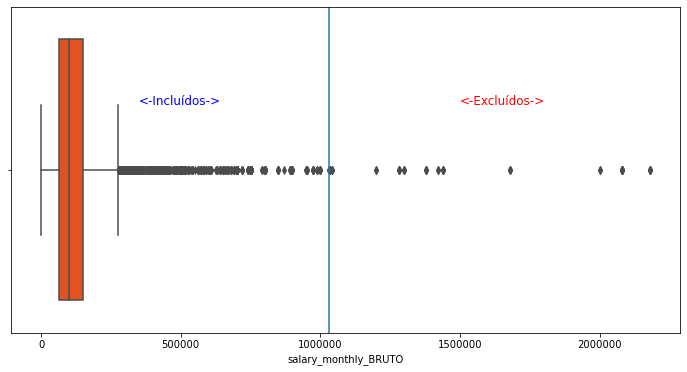

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_lang, x='salary_monthly_BRUTO',color='orangered')
plt.axvline(1031254.375)
plt.text(350000,-0.2, '<-Incluídos->',size=12, color = 'blue')
plt.text(1500000,-0.2, '<-Excluídos->',size=12, color='red')
plt.ticklabel_format(style='plain', axis='x')

Generamos un nuevo dataframe "df_filtered", filtrando aquellos valores que estén por debajo de **30.000** y por encima de **1.031.254,375** en salario bruto. Para los valores que están por debajo del monto, buscamos incluir datos cercanos al salario mínimo y que se acerquen a una distribución normal en los histogramas de cada población.

In [10]:
minumum_salary=30000
maximum_salary=1031254.375
columna_salario = 'salary_monthly_BRUTO'

df_filtered = df_lang.loc[(df_lang[columna_salario] > minumum_salary) & (df_lang[columna_salario] < maximum_salary)].sort_values(by=columna_salario, ascending=False).reset_index(drop=True)

pop_mean = df_filtered[columna_salario].mean()
pop_median = df_filtered[columna_salario].median()
df_greater_pop_mean = df_filtered[df_filtered[columna_salario] > pop_mean]
prob_greater_pop_mean = len(df_greater_pop_mean) / len(df_filtered)

## Generación dataset final

Iteramos sobre **df_filtered** para hacer los análisis sobre las distintas poblaciones de lenguages. Nos interesan los lenguages con mas de 50 programadores, ya que consideramos que tienen un espacio de muestra que exhiben una conclusión representativa. Se termina con **df_final_metrics** que tiene toda la estadística descriptiva para responder a las preguntas del ejercicio.

In [11]:
list_of_languages = df_filtered['programming_language'].unique()

df_columns = ['Language','n_programmers','subpop_Salary_mean','subpop_Salary_median','subpop_Central_Diff','within_subpop_>avg','conditional_prob','pop_prob','cond_ratio','pop_mean']
df_final_metrics = pd.DataFrame(columns= df_columns)
data = []

number_of_programmers_cutoff = 50

for item in list_of_languages:
  
    selected_language_dataframe = df_filtered[df_filtered['programming_language'] == item]
    subpop_programmers_number = len(selected_language_dataframe)

    if subpop_programmers_number > number_of_programmers_cutoff:

        subpop_mean = round(selected_language_dataframe[columna_salario].mean(),2)
        subpop_median = round(selected_language_dataframe[columna_salario].median(),2)
        subpop_above_mean_prob = len(selected_language_dataframe[selected_language_dataframe[columna_salario] > subpop_mean]) / len(selected_language_dataframe)
        subpop_central_diff = subpop_mean - subpop_median
        df_within_subpop_above_avg_salary = selected_language_dataframe[selected_language_dataframe[columna_salario] > subpop_mean]
        prob_within_subpop_above_avg_salary = len(df_within_subpop_above_avg_salary) / len(selected_language_dataframe)

        df_intersection =  (df_lang.programming_language == item) & (df_lang.salary_monthly_BRUTO > pop_mean)
        conditional_prob = sum(df_intersection) / len(selected_language_dataframe)
        subpop_pop_cond_ratio = conditional_prob/prob_greater_pop_mean

        values = [item,subpop_programmers_number,subpop_mean,subpop_median,subpop_central_diff,round(prob_within_subpop_above_avg_salary,2),round(conditional_prob,2),round(prob_greater_pop_mean,2),round(subpop_pop_cond_ratio,2),round(pop_mean,2)]
        zipped = zip(df_columns, values)
        a_dictionary = dict(zipped)
        data.append(a_dictionary)

df_final_metrics = df_final_metrics.append(data, True)
df_final_metrics = df_final_metrics.sort_values('cond_ratio', ascending=True).reset_index(drop=True)

In [12]:
df_final_metrics.sort_values('cond_ratio', ascending=False)

,Language,n_programmers,subpop_Salary_mean,subpop_Salary_median,subpop_Central_Diff,within_subpop_>avg,conditional_prob,pop_prob,cond_ratio,pop_mean
24,scala,111,215080.60,180266.0,34814.60,0.35,0.71,0.33,2.14,135041.36
23,go,294,200392.67,161500.0,38892.67,0.31,0.64,0.33,1.91,135041.36
22,kotlin,182,176433.76,150000.0,26433.76,0.37,0.60,0.33,1.82,135041.36
21,ruby,145,219022.81,150000.0,69022.81,0.32,0.56,0.33,1.68,135041.36
20,swift,100,184244.00,142500.0,41744.00,0.33,0.54,0.33,1.62,135041.36
19,groovy,162,158416.71,136500.0,21916.71,0.38,0.51,0.33,1.54,135041.36
18,cobol,79,142121.52,120000.0,22121.52,0.35,0.43,0.33,1.29,135041.36
17,java,1385,138683.26,119000.0,19683.26,0.39,0.40,0.33,1.19,135041.36
16,python,1418,147065.22,118168.5,28896.72,0.34,0.39,0.33,1.17,135041.36
15,bash/shell,957,144461.49,120000.0,24461.49,0.34,0.38,0.33,1.15,135041.36


El siguiente gráfico permite determinar el Top 3 de lenguajes de programación asociados a una mayor probabilidad de percibir un mejor salario. El parámetro cuantitativo utilizado es el Ratio entre la probabilidad condicional de ganar salarios por encima de la media de cada subpoblación de lenguajes y la probabilidad de ganar por sobre la media en la población global de programadores. Ese valor se denomina AAR (Above Average Ratio), y funciona con mayor poder descriptivo que la Media, dado que está basado en probabilidades.

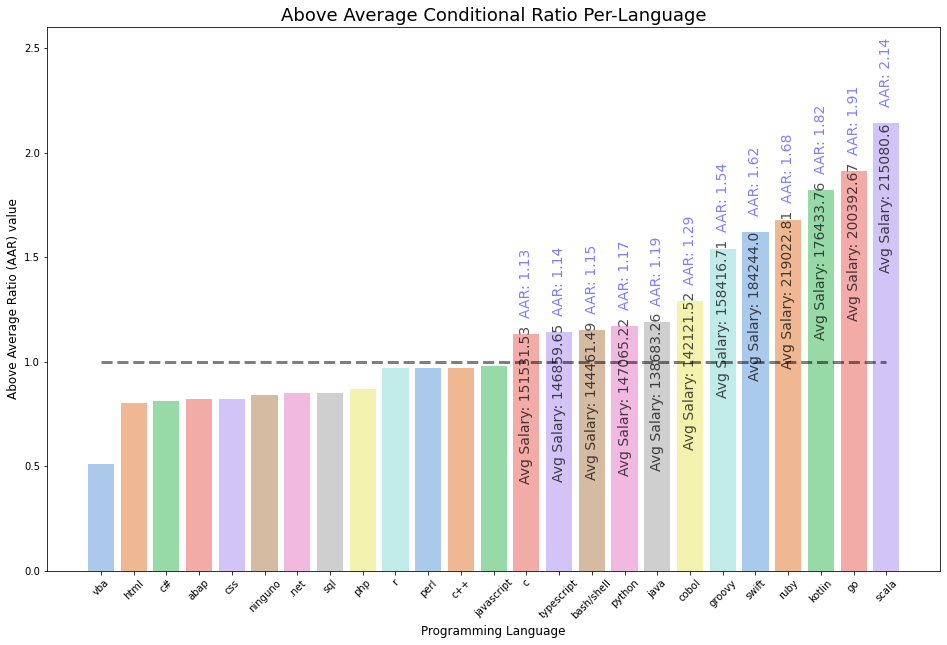

In [43]:
fig = plt.figure(figsize=(16,10))
ax = sns.barplot(x=df_final_metrics.Language, y=df_final_metrics.cond_ratio, data=df_final_metrics, palette='pastel')
ax = sns.lineplot(x=df_final_metrics.Language, y=1.0, data=df_final_metrics, linestyle='dashed',linewidth=3,color='black', alpha=0.5)
plt.xticks(rotation=45)
plt.ylim([0,2.6])
plt.xlabel('Programming Language',size=12)
plt.ylabel('Above Average Ratio (AAR) value',size=12)
plt.title('Above Average Conditional Ratio Per-Language', size=18)

for lang,mean,ratio in zip(df_final_metrics.Language,df_final_metrics.subpop_Salary_mean,df_final_metrics.cond_ratio):
    if ratio > 1:
        ax.text(lang,ratio+0.05,'  AAR: {}'.format(ratio),size=14,color='blue',ha='center',rotation=90, alpha=0.5)
        ax.text(lang,ratio-0.7,'Avg Salary: {} '.format(mean),size=14,color='black',ha='center',rotation=90, alpha=0.7)

Conociendo los 12 lenguages que tienen un AAR mayor a 1, tiene sentido ver un histograma de la distribución de salarios para cada subpoblación y visualizar que no hay datos atípicos mas allá de la ligera asimetría hacia salarios mas altos.

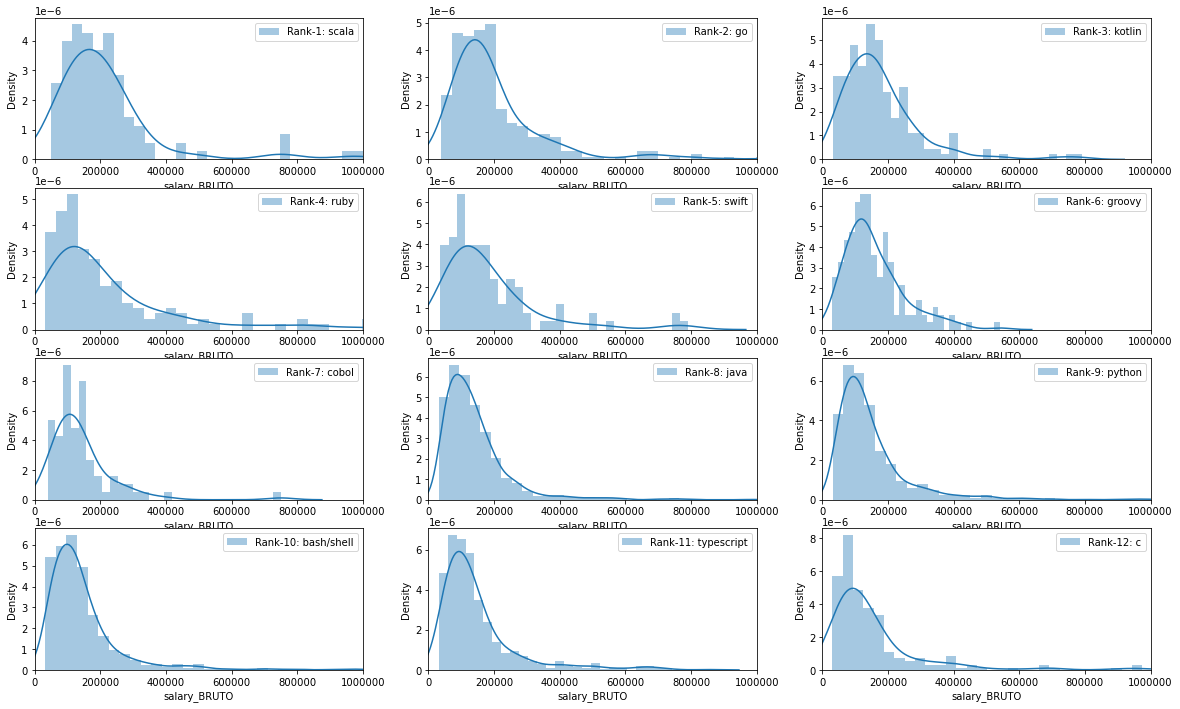

In [12]:
items_altos = df_final_metrics[-12:].Language.iloc[::-1] 
fig = plt.subplots(figsize=(20,12))

for index, item in enumerate(items_altos):
    plt.subplot(4, 3, index + 1)
    df_analysis = df_filtered[df_filtered['programming_language'] == item]
    sns.distplot(x=df_analysis['salary_monthly_BRUTO'],bins=30,label='Rank-{}: {}'.format(index+1,item))
    plt.xlim([0,1000000])
    plt.xlabel('salary_BRUTO')
    plt.ticklabel_format(style='plain', axis='x')
    plt.legend()


# ¿Cuáles son los lenguajes de programación asociados a los mejores salarios?

Luego del análisis realizado y basandonos en el **AAR (Above Average Ratio)** calculado, podemos concluir que los lenguajes de programación asociados a los mejores salarios son, de mayor a menor:
- Scala
- Go
- Kotlin

# Ejercicio 2 - Densidades y varias variables

Responder a la pregunta general: **¿Que herramientas (prácticas y teóricas) són útiles para explorar la base, descubrir patrones, asociaciones?**

Para ello considere (igual al ejercicio Anterior):
1. Seleccionar las columnas relevantes para analizar.
2. Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en sub-poblaciones. 

Decidimos quedarnos con las variables que vamos a utilizar en este segundo ejercicio, para hacer una limpieza rápida de las mismas, y luego utilizar este dataset como base para los próximos cálculos.

In [45]:
columns = ['profile_age', 'profile_years_experience', 'work_people_in_charge_of', 'profile_gender','work_has_violence_situations','salary_monthly_BRUTO', 'salary_monthly_NETO','profile_studies_level']
df[columns].describe().round()

,profile_age,profile_years_experience,work_people_in_charge_of,salary_monthly_BRUTO,salary_monthly_NETO
count,6095.0,6095.0,6095.0,6095.0,5883.0
mean,41.0,9.0,2.0,124059.0,94908.0
std,666.0,7.0,33.0,122912.0,96862.0
min,18.0,0.0,0.0,1.0,1.0
25%,27.0,3.0,0.0,61595.0,51480.0
50%,31.0,7.0,0.0,96000.0,78000.0
75%,37.0,13.0,0.0,145000.0,106000.0
max,52000.0,115.0,2500.0,2180000.0,2080000.0


Viendo las columnas numéricas, vemos que existen outliers en:
- 'profile_age': Hay una edad de 52000, lo cual indica que hay **al menos** 1 registro incorrecto. Ponemos un tope a esta columna en 100 (años) por un sentido biológico.
- 'profile_years_experience': Vemos que existe un registro en 115 (años), lo cual tampoco tiene sentido considerando el corte 'profile_age' a 100 años. Para ser consistentes filtramos esta columna también en 100 años.
- 'work_people_in_charge_of': Existe un registro de 2500, por lo tanto lo eliminamos de la muestra por considerarlo **dato atípico**. 
- Salarios: usamos la misma estrategia que antes, nos quedamos con los sueldos netos comprendidos entre \\$30000 y \\$1031254,37.

Una vez identificados los filtros, generamos un nuevo dataset (df_2) aplicando los filtros antes mencionados para quedarnos con un dataset limpio.

In [46]:
minumum_salary=30000
maximum_salary=1031254.375
columna_salario = 'salary_monthly_NETO'
df_2 = df[columns]
df_2 = df_2[df_2.profile_age < 100]
df_2 = df_2[df_2.work_people_in_charge_of < 2500]
df_2 = df_2[df_2.profile_years_experience < 100]
df_2 = df_2[(df_2[columna_salario] > minumum_salary) & (df_2[columna_salario] < maximum_salary)]
df_2.head()

,profile_age,profile_years_experience,work_people_in_charge_of,profile_gender,work_has_violence_situations,salary_monthly_BRUTO,salary_monthly_NETO,profile_studies_level
0,26,3.0,0,Mujer,En mi trabajo actual,53000.0,43000.0,Universitario
1,29,5.0,4,Hombre,Jamás,79000.0,63000.0,Universitario
2,22,2.0,0,Mujer,En un trabajo anterior,160000.0,127000.0,Secundario
3,39,15.0,5,Hombre,En mi trabajo actual,130000.0,102000.0,Posgrado
4,32,9.0,0,Hombre,Jamás,140000.0,106000.0,Universitario


## a) Densidad conjunta

### Que herramientas visuales y modelos puede utilizar para estudiar la distribución y comportamiento de sus datos? 

Dado un conjunto de datos a analizar, la primera exploración visual resulta importante a los fines de conocer la distribución de los datos. Para ello utilizaríamos una serie de histogramas, si es que se desea hacer análisis por subconjuntos (como en el ejemplo de las celdas de arriba), y un histograma general si se quiere analizar el comportamiento de todos los datos juntos. Luego si se quiere profundizar sobre alguna población general de datos se pueden analizar diagramas del tipo 'boxplot' para evaluar la distribución de los datos.

### Elija tres variables numéricas y 2 variables categóricas. Visualice la base según varias de las variables elegidas. Puede describir de alguna forma el comportamiento de sus datos? Que herramientas utilizaría? Describa

Existen variables numéricas, tales como: 1.1- Edad ('profile_age'), 1.2-Años de Experiencia ('profile_years_experience') y 1.3-Personal a cargo ('work_people_in_charge_of'). Por otra parte tenemos variables categóricas, tales como: 2.1-Género ('profile_gender') y 2.2-Declara violencia laboral ('work_has_violence_situations').

In [47]:
columns = ['profile_age', 'profile_years_experience', 'work_people_in_charge_of', 'profile_gender', 'work_has_violence_situations']
df_a = df_2[columns]
df_a.head()

,profile_age,profile_years_experience,work_people_in_charge_of,profile_gender,work_has_violence_situations
0,26,3.0,0,Mujer,En mi trabajo actual
1,29,5.0,4,Hombre,Jamás
2,22,2.0,0,Mujer,En un trabajo anterior
3,39,15.0,5,Hombre,En mi trabajo actual
4,32,9.0,0,Hombre,Jamás


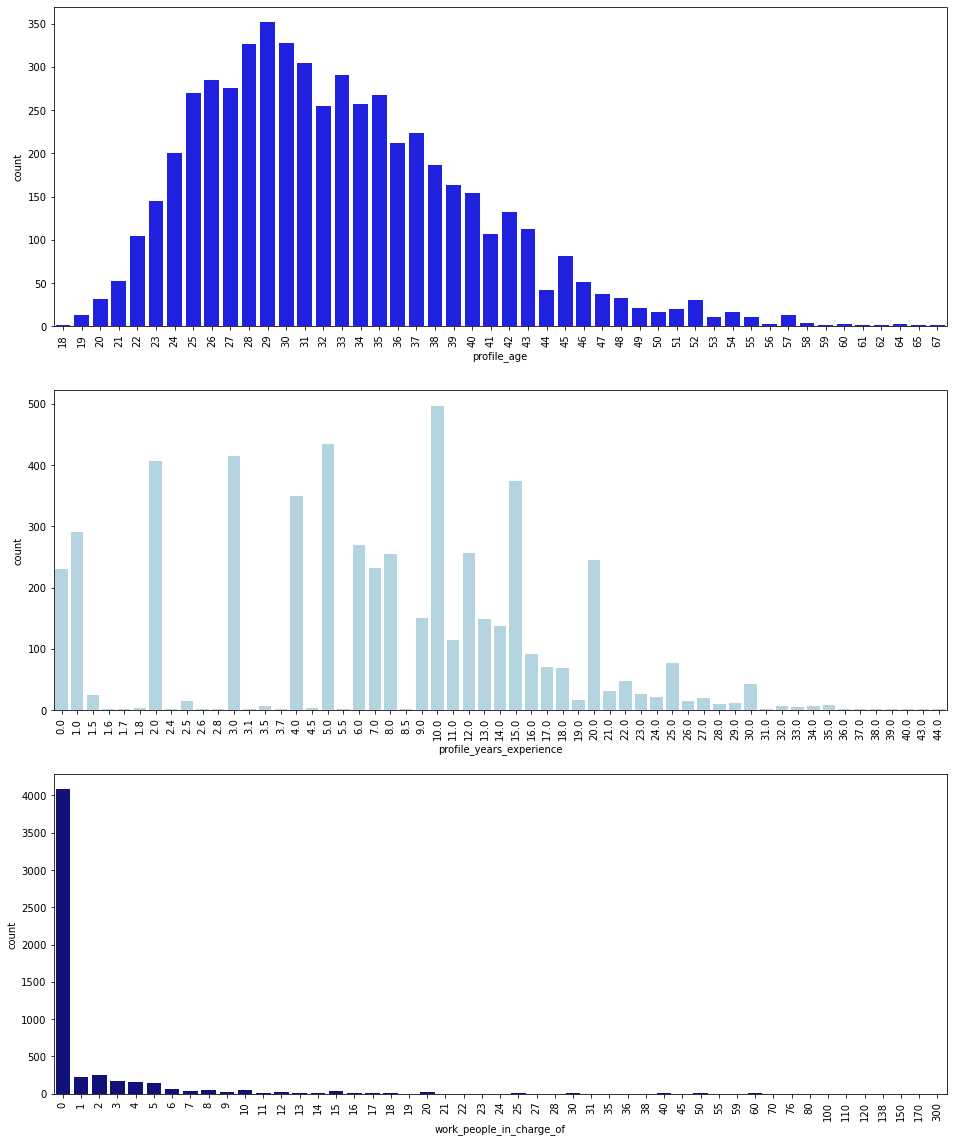

In [48]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16,20))
sns.countplot(df_a['profile_age'], ax=ax[0], color = 'blue')
sns.countplot(df_a['profile_years_experience'], ax=ax[1], color = 'lightblue')
sns.countplot(df_a['work_people_in_charge_of'], ax=ax[2], color = 'darkblue')
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)
ax[2].tick_params(axis='x', rotation=90)

El análisis de la base empleando variables numéricas indica: 
- En relación a la Edad, se observa una distribución normal de la edad de los programadores, comprendiendo un universo de entre 18 y 67 años. Claramente los programadores entre 25-35 años son los numerosos.
- En relación a los años de experiencia, se observa una distribución aleatoria de la experiencia medida en años, con personal de 10 años de experiencia siendo el mas numeroso.
- En relación a la consulta de personas a cargo, claramente la gran mayoría de personas trabajan sin (0) personas a cargo. El trabajo con personal a cargo parece ser mas escaso, disminiyendo con la cantidad de personas dependientes.

<AxesSubplot:xlabel='work_has_violence_situations', ylabel='count'>

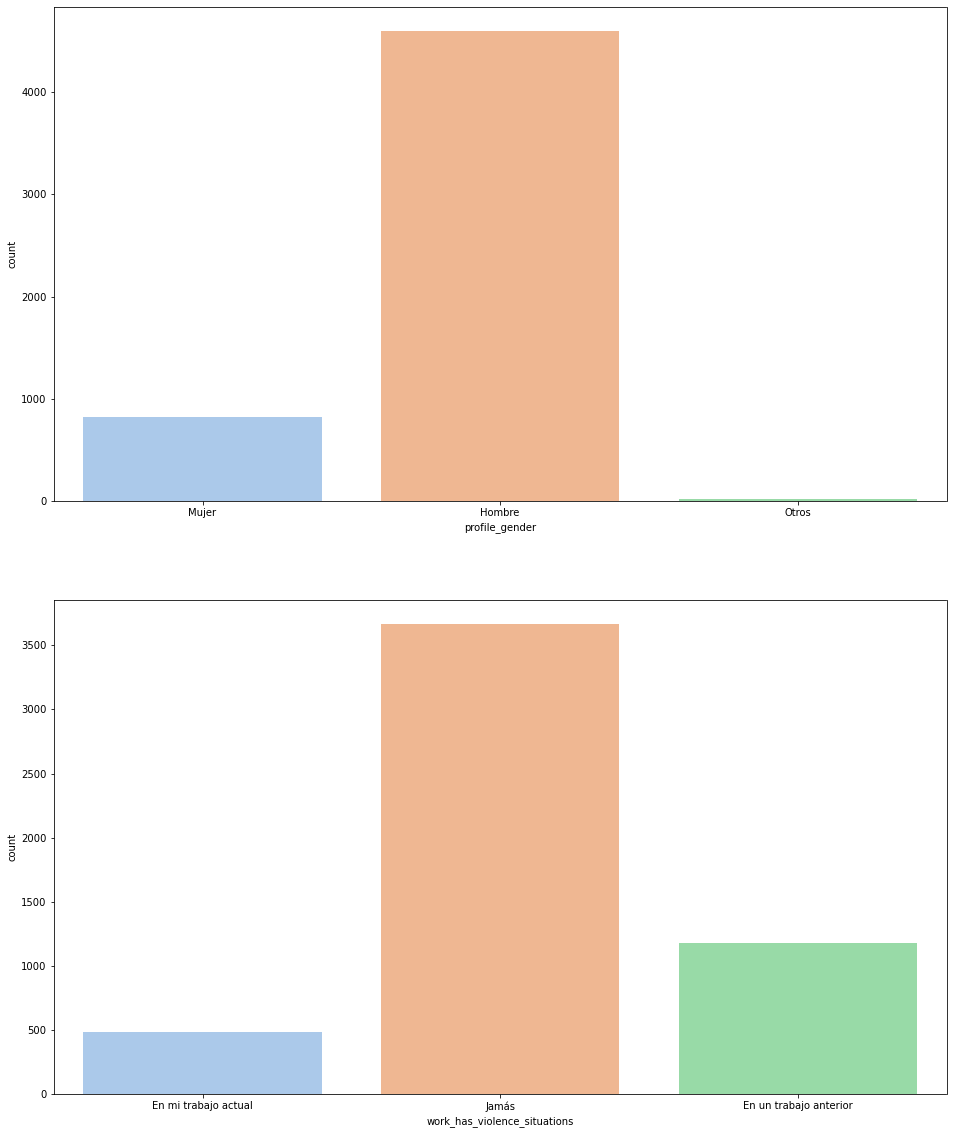

In [49]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,20))
sns.countplot(df_a['profile_gender'], ax=ax[0], palette='pastel')
sns.countplot(df_a['work_has_violence_situations'], ax=ax[1],  palette='pastel')

Mediante el análisis de la base por algunas variables categóricas, se observa que:
- La mayoría que respondió la encuesta son hombres.
- La mayoría nunca ha tenido situaciones violencia laboral.

## b) Asociación

* Necesitamos decidir si sacar o no la columna de salario bruto. Para hacer la encuesta más simple.
¿Existe una correlación entre el salario bruto y el neto? Que abordaje y medidas usaría



In [50]:
df_b = df_2[['salary_monthly_BRUTO', 'salary_monthly_NETO']]

Como primer hipótesis, dado que amban variables estan relacionadas por el hecho de que el salario neto es el salario bruto menos los aportes y deducciones que tenga, es altamente probable que ambas variables tengan una alta correlación. Para hacer un análisis simple, vamos a ver una matriz de correlación para intentar aclarar un poco y deducir si hay o no correlación.

<AxesSubplot:>

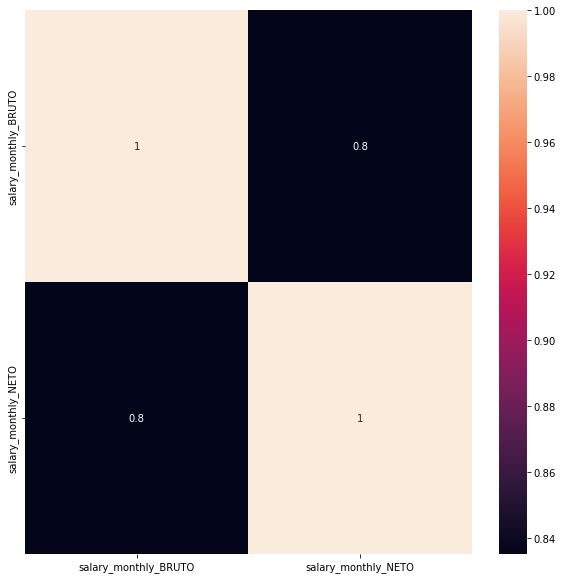

In [51]:
corr = df_b.corr()
fig = plt.figure(figsize=(10,10))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, fmt='.1g')


A primera vista vemos que tienen una correlación positiva de 0.8, lo cual es bastante alto, por lo tanto podemos concluir en que si existe correlación y sería lógico quitar una de las dos para simplificar la encuesta. Pero la pregunta viene a continuación: ¿Cual de los dos salarios conviene quitar?

A continuación vamos a ver la cantidad de valores faltantes en cada columna para ver si éste análisis puede darnos un poco más de claridad.

In [52]:
na_ratio = ((df_filtered[['salary_monthly_BRUTO','salary_monthly_NETO']].isnull().sum() / len(df))*100).sort_values(ascending = False)
print(na_ratio)

salary_monthly_NETO     9.942576
salary_monthly_BRUTO    0.000000
dtype: float64


In [53]:
df_filtered[['salary_monthly_BRUTO','salary_monthly_NETO']].describe().round()

,salary_monthly_BRUTO,salary_monthly_NETO
count,16968.0,16362.0
mean,135041.0,102452.0
std,109890.0,88202.0
min,30250.0,13.0
25%,70000.0,57405.0
50%,104812.0,82000.0
75%,159000.0,113000.0
max,1031250.0,1600000.0


Analizando un poco más los datos descriptivos de cada variable, vemos que el Salario Bruto tiene más coherencia en sus datos, por ejemplo el valor mínimo se encuentra en \\$30250 cuando en el Salario Neto se encuentra en $13 (claramente esto es un error de tipeo y es un outlier, por lo tanto deberia ser removido). 

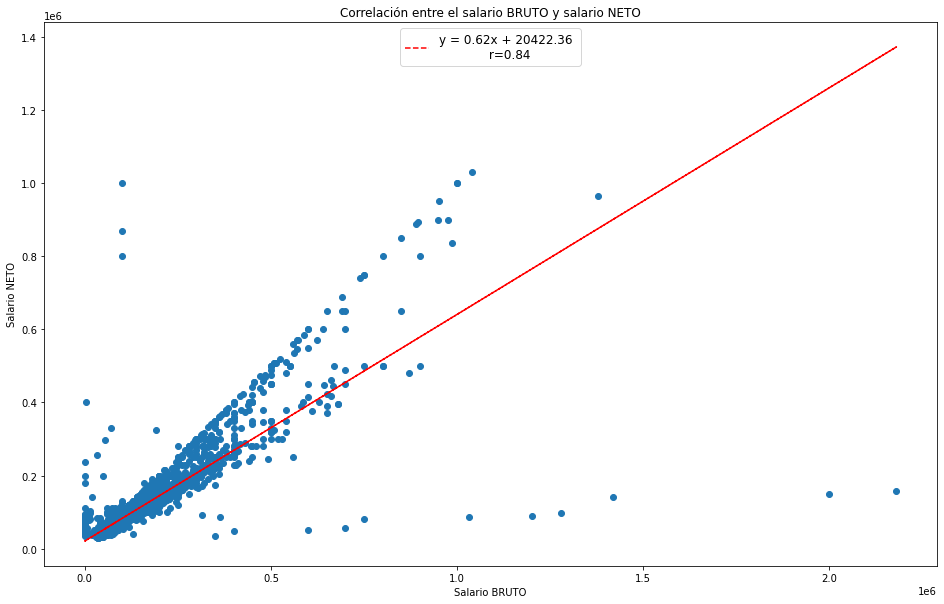

In [54]:
df2 = df_b[df_b['salary_monthly_NETO'].notna()]

fig = plt.figure(figsize=(16,10))
plt.scatter(df2['salary_monthly_BRUTO'],df2['salary_monthly_NETO'])

slope, intercept, r_value, p_value, std_err = stats.linregress(df2['salary_monthly_BRUTO'],df2['salary_monthly_NETO'])

# Calcula la pendiente y ordenada al origen y ploteo la regresión
b, m = np.polyfit(df2['salary_monthly_BRUTO'],df2['salary_monthly_NETO'].dropna(), deg=1)
plt.plot(df2['salary_monthly_BRUTO'], m + b * df2['salary_monthly_BRUTO'] , '--', color='red', label='y = {:.2f}x + {:.2f} \n r={:.2f}'.format(slope,intercept,r_value)) 


plt.title("Correlación entre el salario BRUTO y salario NETO")
plt.xlabel("Salario BRUTO")
plt.ylabel("Salario NETO")
legend=plt.legend(fontsize=12, loc=9)
for t in legend.get_texts():
    t.set_ha('center')

Del análisis visual de la base completa mediante un SCATTERPLOT, se observa un valor de coeficiente de correlación que sugiere correlación de datos (r=0.84), pero el análisis visual demuestra que dicho "r" está originado en una compensación de residuales de ajueste. Por lo tanto consideramos que NO hay correlación TOTAL entre el salario BRUTO y el salario NETO. Sí se observan que hay subgrupos de correlaciones lineales con distintas pendientes, lo cual en el contexto del dominio de los datos se interpreta como que hay distintas poblaciones con configuraciones impositivas diferentes, que llevan entonces a las distintas pendientes (y deducciones del BRUTO). Entonces, dejaríamos la columna del sueldo BRUTO y la utilizaríamos para todo el análisis, quitando la columna del sueldo NETO. 
Si usaramos el suelto NETO para elaborar las conclusiones, estaríamos introduciendo un error al considerar que la población tiene un esquema de deducciones impositivas constante. Si ello fuera imprescindible, se aplicaría algun método analítico para separar la muestras por distintos grupos de correlación BRUTO vs NETO. Luego los análisis estarían confinados a cada subgrupo en particular.

## c) Densidad condicional 

Estudie la distribución del salario según el nivel de estudio.

Separe la población según el nivel de estudio (elija dos subpoblaciones numerosas) y grafique de manera comparativa ambos histogramas de la variable `'salary_monthly_NETO'`
¿Considera que ambas variables son independientes?
¿Qué analizaría al respecto?

Calcule medidas de centralización y dispersión para cada subpoblación






In [55]:
columnas_c = ['profile_studies_level', 'salary_monthly_BRUTO']
df_c = df_2[columnas_c]
df_c.head()

,profile_studies_level,salary_monthly_BRUTO
0,Universitario,53000.0
1,Universitario,79000.0
2,Secundario,160000.0
3,Posgrado,130000.0
4,Universitario,140000.0


Para poder elegir dos subpoblaciones numerosas, vemos el value_counts de la variable "profile_studies_level" y asi elegir las dos que más registros tienen.

In [56]:
df_c.profile_studies_level.value_counts()

Universitario    3714
Terciario        1017
Secundario        388
Posgrado          302
Doctorado          24
Posdoctorado        3
Primario            2
Name: profile_studies_level, dtype: int64

Vemos que las dos variables con más registros son "Universitario" y "Terciario", por lo tanto creamos un nuevo dataframe únicamente con estos registros, para luego poder graficarlos en un barplot. También aplicamos el mismo filtro que usamos en el primer ejercicio, para quedarnos únicamente con los sueldos mayores a \\$30000 y menores a \\$1031254,375.

In [57]:
filtro = ['Universitario','Terciario']
df_c_filtered = df_c[(df_c.profile_studies_level.isin(filtro))]
df_c_filtered.profile_studies_level.value_counts()

Universitario    3714
Terciario        1017
Name: profile_studies_level, dtype: int64

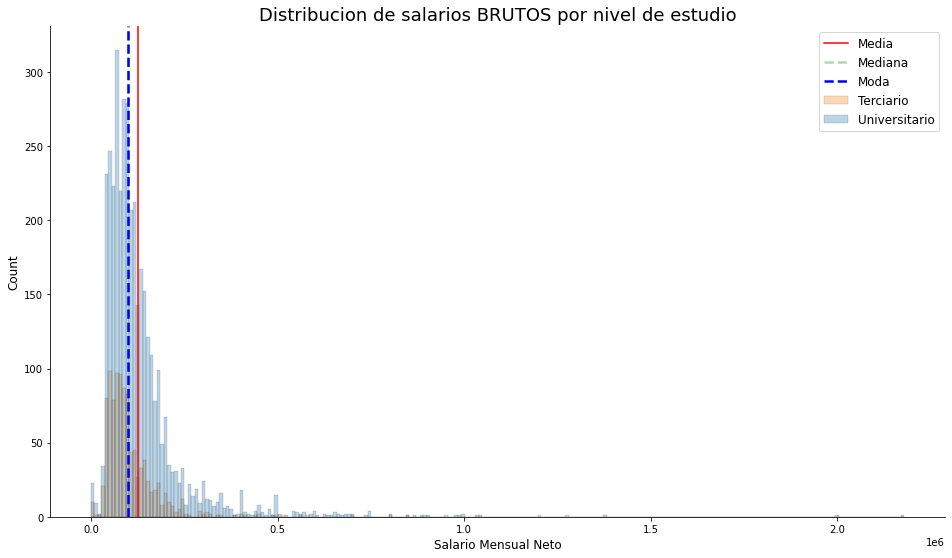

In [58]:
ax = sns.displot(df_c_filtered, x='salary_monthly_BRUTO', hue='profile_studies_level', kind='hist', alpha=0.3, legend=False)
plt.axvline(x=df_c_filtered.salary_monthly_BRUTO.mean(),
            color='red')
plt.axvline(x=df_c_filtered.salary_monthly_BRUTO.median(),
            color='green',
            ls='--', 
            lw=2.5, alpha=0.3)
plt.axvline(x=df_c_filtered.salary_monthly_BRUTO.mode()[0],
            color='blue',
            ls='--', 
            lw=2.5)
plt.xlabel('Salario Mensual Neto',size=12)
plt.ylabel('Count',size=12)
plt.title('Distribucion de salarios BRUTOS por nivel de estudio', size=18)
plt.gcf().set_size_inches(15, 8)
plt.legend(loc='upper right', labels=['Media', 'Mediana','Moda', 'Terciario', 'Universitario'], fontsize='large')
plt.show(fig)

Los histogramas de ambas poblaciones (Universitaria  y Terciaria), se diferencian mediante observación cualitatitiva en la dispersión de datos hacia sueldos mas altos. Eso significa que vale la pena analizar estadísticamente si es que los estudios Universitarios dan mas probabilidad de ganar mas dinero.

In [59]:
for i in set(df_c_filtered.profile_studies_level):
    std = str(format(df_c_filtered[df_c_filtered.profile_studies_level == i]['salary_monthly_BRUTO'].std(),".2f"))
    var = str(format(df_c_filtered[df_c_filtered.profile_studies_level == i]['salary_monthly_BRUTO'].var(),".2f"))
    coef_var = str(format(scipy.stats.variation(df_c_filtered[df_c_filtered.profile_studies_level == i]['salary_monthly_BRUTO'].dropna()),".2f"))
    mean = str(format(df_c_filtered[df_c_filtered.profile_studies_level == i]['salary_monthly_BRUTO'].mean(),".2f"))
    median = str(df_c_filtered[df_c_filtered.profile_studies_level == i]['salary_monthly_BRUTO'].median())
    mode = str(df_c_filtered[df_c_filtered.profile_studies_level == i]['salary_monthly_BRUTO'].mode()[0])
    print("Medidas de dispersión - Nivel de estudio: "+i)
    print("Desvío estándar: "+std)
    print("Varianza: "+var)
    print("Coeficiente de variación: "+coef_var)
    print("Medidas de centralización - Nivel de estudio: "+i)
    print("Media: "+mean)
    print("Mediana: "+median)
    print("Moda: "+mode)
    print("\n")
    

Medidas de dispersión - Nivel de estudio: Terciario
Desvío estándar: 95655.94
Varianza: 9150058210.89
Coeficiente de variación: 0.88
Medidas de centralización - Nivel de estudio: Terciario
Media: 108224.79
Mediana: 86000.0
Moda: 100000.0


Medidas de dispersión - Nivel de estudio: Universitario
Desvío estándar: 116721.06
Varianza: 13623806921.26
Coeficiente de variación: 0.89
Medidas de centralización - Nivel de estudio: Universitario
Media: 130994.64
Mediana: 101750.0
Moda: 100000.0




## d) Densidad Conjunta condicional

Elija dos variables numéricas y una categórica. 
Estudie la dispersión (scatterplot) de las dos variables discriminando en color por la variable categórica (ayuda: hue en seaborn)


In [60]:
columnas = ['profile_gender', 'salary_monthly_BRUTO', 'profile_age']
df_d = df_2[columnas]
df_d.head()

,profile_gender,salary_monthly_BRUTO,profile_age
0,Mujer,53000.0,26
1,Hombre,79000.0,29
2,Mujer,160000.0,22
3,Hombre,130000.0,39
4,Hombre,140000.0,32


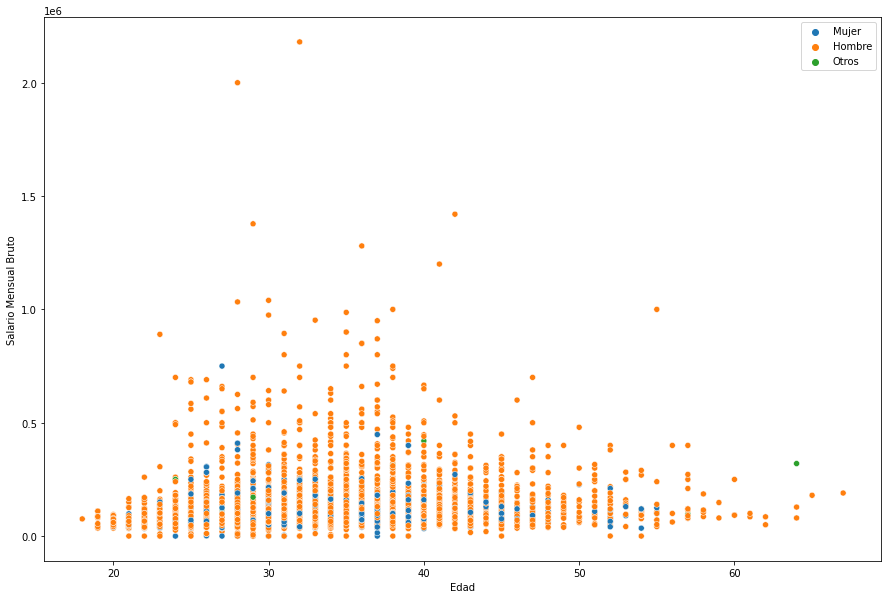

In [61]:
fig = plt.figure(figsize=(15,10))
sns.scatterplot(data=df_d, x="profile_age", y="salary_monthly_BRUTO", hue="profile_gender")
plt.xlabel('Edad')
plt.ylabel('Salario Mensual Bruto')
plt.legend()

El gráfico sugiere que la dispersión de sueldos brutos hacia valores más altos se da en la población de entre 25-35 años. También se observa que valores mas altos son más frecuentes en hombres que en mujeres, y que los primeros alcanzan salarios mayores que las segundas. Por último, a medida que el programador pertenece a rangos etarios hacia los extremos del rango 25-35 años la dispersión hacia salarios mas altos se reduce.